In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import patsy

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "auto_mpg_data.tsv"
auto_mpg_names = "names_auto_mpg.txt"

<a id='v_TOP'></a>

# Problem Set 5

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**

## Introduction

Labs 9 and 10 were all about linear models, specifically linear and logistic regression. We learned how to build and interpret multivariate models by using domain knowledge, comparing the predicted and actual values of the coefficients and the credible intervals, and looking at residuals. We also applied transformations to make the models perform better and increase interpretability.

Using the techniques covered during Modules 9 and 10 (lectures, labs, course notes), **build, describe, and use** a linear regression model that estimates the target variable `mpg` for the accompanying auto data set. You may use other techniques you know but you must at least use the techniques described in class and call out and describe anything "extra" that you do and why.

Do **not** use any feature selection techniques or anything other than linear regression. Follow the method described in class.

The instructions say build, **describe, and use**. You must describe all aspects of your final model (all the parameters and metrics) and use it to predict one value as described in the course notes.

## Hints From BlackBoard

I am adding a few days to the Problem Set 5 deadline.

1. The final, complete assignment is due Sunday, August 16. Yes, it still says August 11. Keep reading.
2. You MUST still submit a milestone by Tuesday, August 11. This milestone will consist of your ETL and EDA for the problem. Failure to submit will result in -1 to your final grade. I will change the deadline for the assignment on August 12.



Pointers

1. You may need to acquire domain knowledge. That domain knowledge should be described and referenced in the notebook.
1. For ETL and EDA, follow the Lab 5 Solution closely. Don't stray from the plot. The entire point of the framework for EDA is to be methodical and scientific.
1. You need to build a linear regression model. This assignment covers modules 9, 10, 11. Use the process outlined in the Lectures and  Fundamentals. Do not use anything other than linear regression.
1. Make sure you actually do 1.5...use the model. You built a model. Make a prediction with it. Calculate the error bounds. This is in the entire point of building a model. There's an example in Fundamentals.

Additional

Please make sure you submit one single notebook. Yes, it's going to get big. Add internal links and a table of contents. However, if you like, you can have your "library" code in a single external file called (your JHED id).py. You can then import it. But only "library code".



### Links

- [ETL](#v_ETL)
- [EDA](#v_EDA)
- [Build Model](#v_build_model)
- [Describe Model](#v_describe_model)
- [Use Model](#v_use_model)

<a id='v_ETL'></a>

## 1.1 - ETL

To begin the ETL process, let's start with taking a look at the columns. The file `names_auto_mpg.txt` contains this information at the bottom

> 7. Attribute Information:
>
>    1. mpg:           continuous
>    2. cylinders:     multi-valued discrete
>    3. displacement:  continuous
>    4. horsepower:    continuous
>    5. weight:        continuous
>    6. acceleration:  continuous
>    7. model year:    multi-valued discrete
>    8. origin:        multi-valued discrete
>    9. car name:      string (unique for each instance)
>
>8. Missing Attribute Values:  horsepower has 6 missing values

From this we can create a list of the names, and load in our data. From inspecting the data file, I also notice that there are some missing values denoted by '?'; we'll instruct pandas to read them as `na_values`

In [3]:
names = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]

mpg = pd.read_csv("auto_mpg_data.tsv", delim_whitespace = True, names = names, na_values="?")

Now let's take a deeper look into our `mpg` data to get an idea of the data types pandas is using, and if we want to change any of them based on the description given above

In [4]:
mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


Comparing this table to what `names_auto_mpg.txt` told us, these data types look pretty good. We can also see those 6 missing values in `horsepower` that it warned us of. 

In [5]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


What we are looking for here is anything that might be off or strange about the way the data looks. For example, if weight had three decimal places, even though the values are in the thousands. However, there do not seem to be any issues of that sort. From a first glance, the columns `mpg`, `displacement`, `horsepower`, and `weight` are all floating point numbers that seem to end in .0. It might be possible to convert them to integers if they never have any more decimal values other than .0

[Back to top](#v_TOP)

---
<a id='v_EDA'></a>
## 1.2 - EDA

### 1.2.1 MPG

MPG (miles per gallon) is a measure of efficiency of a car. Since this data is taken from the 70s and 80s, we can probably expect the average `mpg` to be lower than today's. I would probably expect this to be something like a lognormal curve; most cars clump together a little lower down, and a few have higher mpgs. 

Let's take a look at summary statistics to get a sense of the range, and maybe pick out anomalies (0 mpg, 300 mpg)

In [6]:
mpg.mpg.describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

Nothing shocking here. Let's move on to a histogram

In [7]:
def plot_hist_w_labels(df: pd.DataFrame, col: str):
    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)
    axes.hist(df[col], color="darkslategray")
    axes.set_title(f"Distribution of {col}")
    axes.set_xlabel(col)
    axes.set_ylabel("Frequency")

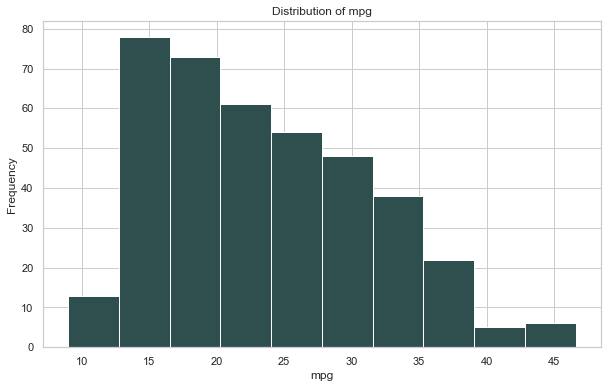

In [8]:
plot_hist_w_labels(mpg, "mpg")

A few things to note, there are few cars with an mpg less than 15, but a majority sit just above 15. From there, frequency steadily declines until we reach 40, at which point there are fewer than we might expect if we follow the pattern. This is not quite the lognormal curve I predicted, but it does have a sharp growth to a maximum, and a "tail" to the right.

### 1.2.2 Cylinders

`cylinders` refers to the number of cylinders in a car's engine. Generally, the more cylinders a car has, the more gas it can combust at once, the more horsepower it has. More cylinders also usually corresponds with lower MPG. There are almsot always an even number of cylinders to match the vibrations; as one goes up, another goes down, or the whole engine might shake itself apart. 
![Car Engine](img/car_engine.jpg)

Note that in some notable cases, they do not need an even number due to configuration. Take, for example, this airplane engine which places cylinders in a circle around the drive shaft.
![Plane Engine](img/airplane_engine.jpg)

I would expect this go between maybe 2 and 12 cylinders; 12 being something like the number of cylinders in a possible supercar

In [9]:
mpg.cylinders.describe()

count    398.000000
mean       5.454774
std        1.701004
min        3.000000
25%        4.000000
50%        4.000000
75%        8.000000
max        8.000000
Name: cylinders, dtype: float64

The minimum is 3 cylinders, which is slightly unexpected. The max is 8, already plenty for a supercar. Let's see how many of each there are:

In [10]:
mpg.cylinders.value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

Most are either 4, 8, or 6. A very few have 3 or 5 cylinders. 

Because there are distinct numbers of cylinders, let's use a bar chart instead of a histogram.

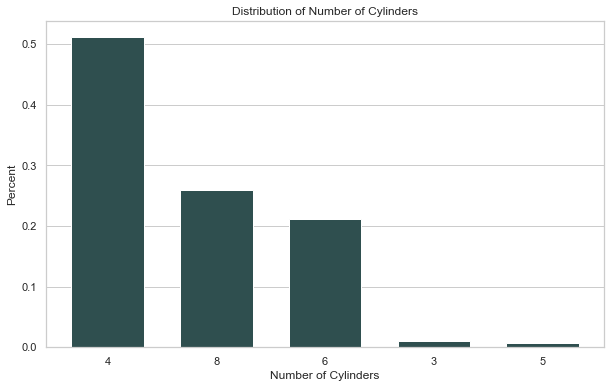

In [11]:
data = mpg.cylinders.value_counts(normalize=True)
x = range( len( data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, data, width, align="center", color="darkslategray")
axes.set_xticks([0, 1, 2, 3, 4])
axes.set_xticklabels(data.axes[0])
axes.set_title("Distribution of Number of Cylinders")
axes.set_xlabel("Number of Cylinders")
axes.set_ylabel("Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

Over half the cars have 4 cylinder engines, around 20-25% have 8 or 6 cylinders, and a very few percent have 3 or 5.

### 1.2.3 Displacement

`displacement` refers generally to the total volume displaced by the pistons. The larger the displacement, the more air is combusting with your gas (and you've probably injected more gas as well), which means more powerful combustion, which means higher horsepower (usually), and lower efficiency (usually). It is possible to have a high displacement engine that is efficient when run at low rpms. Often, displacement is measured in cc (cubic centimeters), but we don't know for sure that that is the unit used in this dataset. 

I would expect that the distribution of displacement looks like a flipped version of `mpg`'s, as the lower displacement cars are probably more efficient.

In [12]:
mpg.displacement.describe()

count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%      148.500000
75%      262.000000
max      455.000000
Name: displacement, dtype: float64

No surprises here, a minimum of 68, and a maximum of 455. I would probably assume that the units are in cc. 

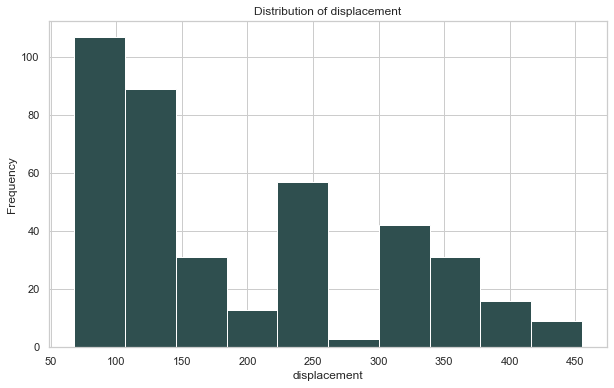

In [13]:
plot_hist_w_labels(mpg, "displacement")

If displacement were driven only by engineering "goodness", fun, and efficiency, I would expect a continuous-looking distribution. This is clearly not a continuous distribution. The overall trend is generally decreasing, but with large gaps where we would expect to see more cars with a given displacement. One possible reason for this is [governmental regulations](https://en.wikipedia.org/wiki/Engine_displacement#Governmental_regulations). For example, at the time these cars were created, there might have been a larger tax on cars with displacements above 250. Hence, many cars go right up to the limit of 250, very few go just above it. And at around 300, this consideration probably goes away as cars get more into the land of expensive sports cars and muscle cars, where people are more willing to pay for more power.

### 1.2.4 Horsepower

Horsepower is a measure of energy produced per second (1 hp $\approx$ 745.7 W). I would haved expected this to be something like a lognormal curve. Howerver, given the distribution of displacement that we have seen, I would hesitate to expect a continuous-looking distribution. 

In [14]:
mpg.horsepower.describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

There is a minimum of 75hp and a max of 230. These numbers are pretty reasonable. We should also remember that six of the values are missing, and marked as `NaN` in our dataframe. 

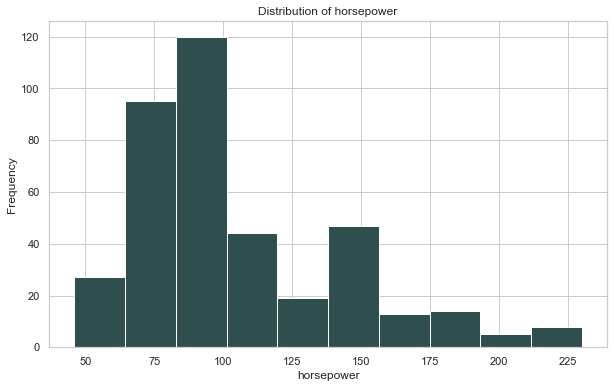

In [15]:
plot_hist_w_labels(mpg, "horsepower")

There is something of a lognormal curve here, but there is a very clear jump around 150 hp. Was 150hp a 'magic number' in the 70s and 80s, where cars with that much power sold better? 

### 1.2.5 Weight

The weight of these cars is probably measured in pounds. I would expect that it probably goes from around 2000 lbs to over 4000. Generally, I would expect that manufacturers wish most cars wish to weigh as little as possible. Start from Newton's second law:
$$ F = m \cdot a $$
This tells us that the smaller the mass, the less force is needed to achieve a given acceleration. Since the force applied at the wheels is proportional to the horsepower, this means a car can get away with producing less horsepower to achieve a given acceleration if it weighs less. 

Let's look at Newton's second law another way:
$$ a = \frac{F}{m} $$
From this perspective, if I want a car to accelerate quickly, I can reduce its mass. If I'm designing a sports car, I probably want it to accelerate quickly. Therefore it behooves me to mak ethe car weigh as little as possible. 

That said, there are other reasons that efficiency and acceleration for buying a car. I may want to buy a pickup that can carry a lot of weight, or tow a large trailer. In that case, mass is a secondary consideration, and may be larger.

With that in mind, I would expect that most cars try to weight as little as possible, while some weight significantly more.

In [16]:
mpg.weight.describe()

count     398.000000
mean     2970.424623
std       846.841774
min      1613.000000
25%      2223.750000
50%      2803.500000
75%      3608.000000
max      5140.000000
Name: weight, dtype: float64

The minimum weight is 1613lb, and the max is 5140lb. A slightly larger spread than I expected, but still reasonable. 

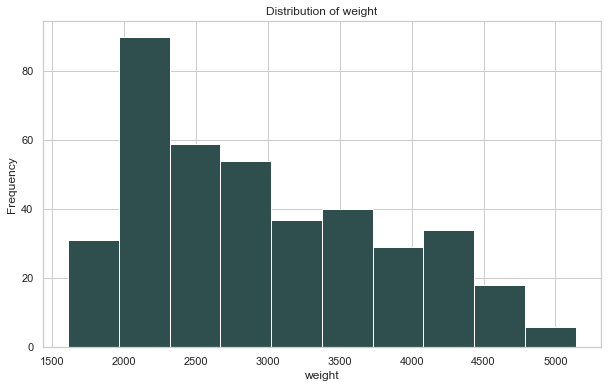

In [17]:
plot_hist_w_labels(mpg, "weight")

The overall shape of this histogram is very similar to that of the `mpg` column. There are a few cars between 1500lb and 200lb; a clear peak between 2000lb and 2500lb, and a gradual descent till 5000lb. A tendency to lower weights makes a lot of sense with the discussion we had above about the affects on a car of a lower weight. 

### 1.2.6 Acceleration

Acceleration is the change in velocity per unit time. Example units might be $\frac{m}{s^2}$, or $\frac{ft}{s^2}$. I won't try to guess the units of acceleration for this dataset. Going back again to Newton's second law:

$$ a = \frac{F}{m} $$

We can see that greater acceleration requires either larger force, smaller mass, or both. Since mass is inversely proportional to acceleration, we would expect that cars weighing less will accelerate faster than cars weighing more. This would suggest the acceleration distribution might look something like that of `weight`. However, acceleration is directly proportional to force, which is proportional to horsepower, so this may change the distribution a bit.

In [18]:
mpg.acceleration.describe()

count    398.000000
mean      15.568090
std        2.757689
min        8.000000
25%       13.825000
50%       15.500000
75%       17.175000
max       24.800000
Name: acceleration, dtype: float64

There is a minimum value of 8 and a maximum of 24.8. Nothing looks unexpected here. 

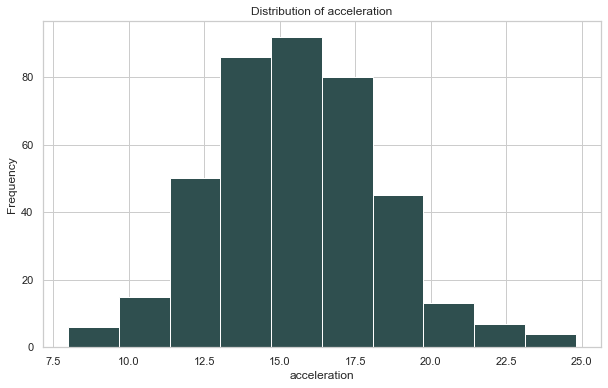

In [19]:
plot_hist_w_labels(mpg, "acceleration")

This distribution looks very close to a normal, or perhaps lognormal curve. I was expecting the curve to have a little more of a tail to the right. I expected most cars to have lower acceleration, and a few to have much higher. I would be very interested to see how this curve would look with modern cars. 

### 1.2.7 Model Year

Model year is a "multi-valued discrete" feature. I would expect the numbers to be more or less constant throughout the years this data was recorded from. 

In [20]:
mpg.model_year.describe()

count    398.000000
mean      76.010050
std        3.697627
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: model_year, dtype: float64

The model years go from 1970 to 1982. 

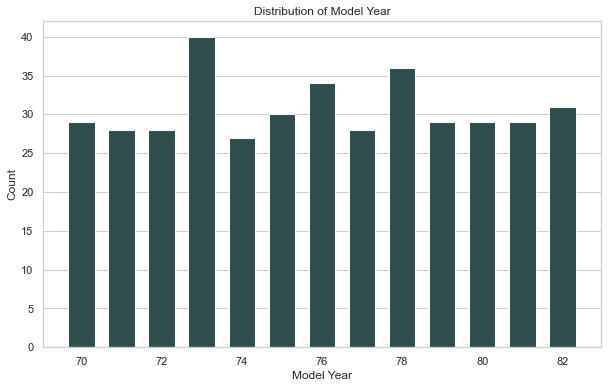

In [21]:
data = mpg.model_year.value_counts(sort=False)
x = range( len( data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(data.index, data, width, align="center", color="darkslategray")
axes.set_title("Distribution of Model Year")
axes.set_xlabel("Model Year")
axes.set_ylabel("Count")
axes.xaxis.grid(False)

plt.show()
plt.close()

There are usually a little under 30 cars per model year. In a few cases, there are a larger number, 1973 in particular. This is pretty close to what I expected of an almost consistent number of cars per year. 

### 1.2.8 Origin

Origin, like cylinders and model year is a multi-valued discrete column. Having seen a few rows of it, we know that it is encoded here as integers. Likely, these integers correspond to something like the name of a country. I would imagine that there are not too many of these. Let's take a look at the value counts

In [22]:
mpg.origin.value_counts()

1    249
3     79
2     70
Name: origin, dtype: int64

Lots from origin 1, and some from origins 2 & 3. 

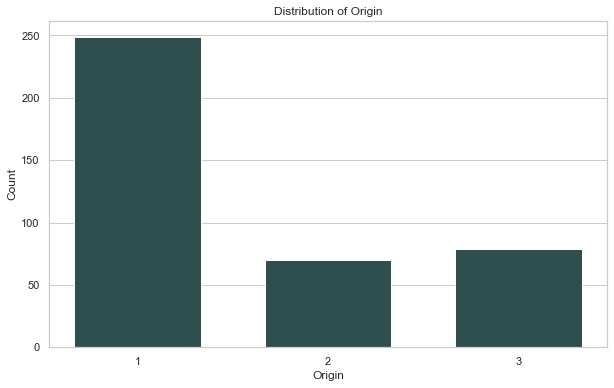

In [23]:
data = mpg.origin.value_counts(sort=False)
x = range( len( data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(data.index, data, width, align="center", color="darkslategray")
axes.set_xticks([1, 2, 3])
axes.set_title("Distribution of Origin")
axes.set_xlabel("Origin")
axes.set_ylabel("Count")
axes.xaxis.grid(False)

plt.show()
plt.close()

Clearly there are almost 3 times as many cars coming from origin 1 as 2 and 3. I would guess that maybe origin 1 is the US, and 2 and 3 are perhaps Japan and Germany. 

### 1.2.9 Car Name

We've seen by looking at the first few rows of the car that the `car_name` column has the make, and then the model. This means we could have quite a few unique names. Let's see how many

In [24]:
mpg.car_name.nunique()

305

There are 305 unique make-model combinations; quite a lot considering that there are 398 records total. Perhaps we can get some idea of how many unique makes are represented in this column

In [25]:
makes = mpg.car_name.str.split().apply(lambda x: x[0])
makes.describe()

count      398
unique      37
top       ford
freq        51
Name: car_name, dtype: object

It looks like there are 37 unique makes represented in this dataset, with the most common being Ford with 51 records. Let's plot the distribution of makes

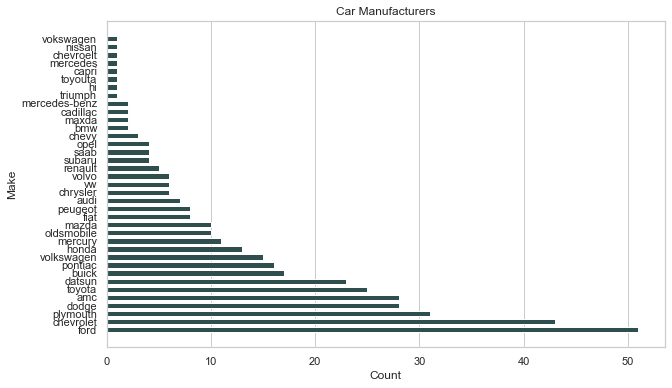

In [26]:
data = makes.value_counts(sort=True)
x = range( len( data))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.barh(data.index, data, width, align="center", color="darkslategray", )
axes.set_title("Car Manufacturers")
axes.set_xlabel("Count")
axes.set_ylabel("Make")
axes.yaxis.grid(False)

plt.show()
plt.close()

Looking at this tells us a couple things:

- The three origins are not the USA, Japan and Germany. Rather, it is likely they are North America (US?), Europe, and Asia (Japan?). We can say this because there are several European makes beyond German ones: Saab, Opel, Renault, Peugeot, Volvo, and Fiat.
- The naming conventions are not consistent
  - There are some labeled `vw` and others labeled `volkswagen`. Same for chevrolet and mercedes.
- There are some labels that have probably been mistyped:
  - `maxda` instead of `mazda`
  - possibly some others that I've missed

## Pairwise EDA: MPG vs. ???

Since the goal of this problem set is to build a model predicting mpg, let's compare mpg to the other columns.

To begin, let's write out how we think each column might affect `mpg`

1. cylinders:     negatively. As `cylinders` goes up, I think `mpg` will generally go down. 
3. displacement:  negatively. As `displacement` goes up, I think `mpg` will generally go down. 
4. horsepower:    negatively. As `horsepower` goes up, I think `mpg` will generally go down. 
5. weight:        definitely negatively. I believe `weight` will be one of the strongest predictors of `mpg`. 
6. acceleration:  negatively. As `acceleration` goes up, I think `mpg` will generally go down. 
7. model year:    somewhat positively. The US implemented [corporate average fuel economy](https://en.wikipedia.org/wiki/Corporate_average_fuel_economy) regulations on cars in the US starting in 1978. At this point, I would expect the year to start correlating positively with `mpg`. Before this, I do not expect to see much in the way of trends. 
8. origin:        slightly harder to say. I would guess that average `mpg` goes from largest to smallest in the order Japanese, American, German. However, I would also expect that the relative differences will be small, and that this will not be a very good predictor overall. 
9. car name:      No effect. Since the name is pretty much unique for each row, there isn't really a good way to do regression with this. It's probably not worth examining beyond looking at the cars with max and min `mpg`.

In order of how important they will be to regression, I think it'll be 

1. [weight](#v_weight)
1. [acceleration](#v_acceleration)
1. [model year](#v_model_year)
1. [cylinders](#v_cylinders)
1. [horsepower](#v_horsepower)
1. [displacement](#v_displacement)
1. [origin](#v_origin)

<a id="v_weight"></a>

### 1.2.10 MPG vs. Weight

The more a car weighs, the more energy must be spent to accelerate it. I believe this relationship will very likely be monotonic, and probably linear

In [27]:
print("r = ", stats.pearsonr(mpg.mpg, mpg.weight)[0])
print("ρ = ", stats.spearmanr(mpg.mpg, mpg.weight)[0])

r =  -0.831740933244335
ρ =  -0.8749473981990713


The sign of the correlation is negative, as expected. Pearson's value of -0.83 means that there is a pretty strong linear correlation between the two. However, Spearman's value shows even stronger correlation. Overall, this suggests that there is a strong linear relationship, but even stronger evidence that it might not be just linear. Let's plot the data

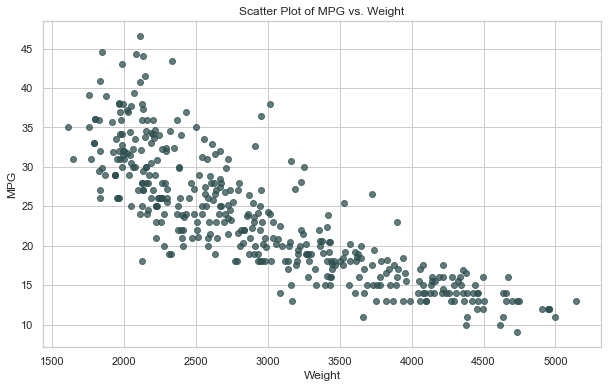

In [28]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(mpg.weight, mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("Weight")
axes.set_title("Scatter Plot of MPG vs. Weight")

plt.show()
plt.close()

Yes, there is definitely some strong negative linear correlation between `charges` and `weight`. However, at lower weights, there is a little more spread in the data, and also possibly a bit of an upward curve. If we make the relationship reciprocal, what does it look like?

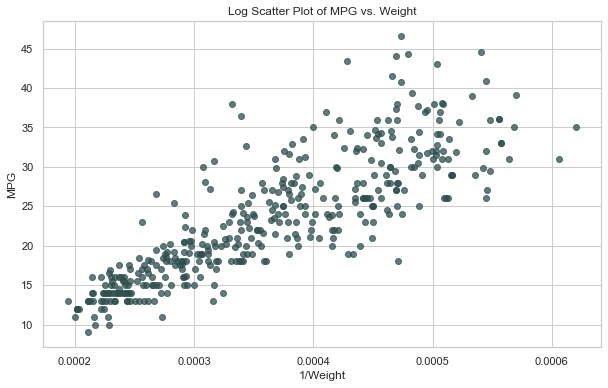

In [29]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(1/mpg.weight, mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("1/Weight")
axes.set_title("Log Scatter Plot of MPG vs. Weight")
# axes.set_yscale("log")

plt.show()
plt.close()

Peronally, I would say that that looks more linear. Do the correlation coefficients agree with that?

In [30]:
print("r = ", stats.pearsonr(mpg.mpg, 1/mpg.weight)[0])
print("ρ = ", stats.spearmanr(mpg.mpg, 1/mpg.weight)[0])

r =  0.8407238858220246
ρ =  0.8749473981990713


Spearman's has not changed much at all, but Pearson's now almost matches Spearmans! This suggests that a reciprocal transform may be useful in building the model.

<a id="v_acceleration"></a>

### 1.2.11 MPG vs. Acceleration

`acceleration` in this dataset likely refers to the maximum acceleration possible with the car. The act of accelerating harder requires either more force, less mass, or both. In this case, I would assume that cars with greater acceleration capabilities have a lower `mpg`. I would guess that the relationship is vaguely linear in shape.

In [31]:
print("r = ", stats.pearsonr(mpg.mpg, mpg.acceleration)[0])
print("ρ = ", stats.spearmanr(mpg.mpg, mpg.acceleration)[0])

r =  0.4202889121016507
ρ =  0.4386774795708622


This shows a positive correlation, which is surprising. Let's talk about that more after plotting the data. Let's take a look at a plot.

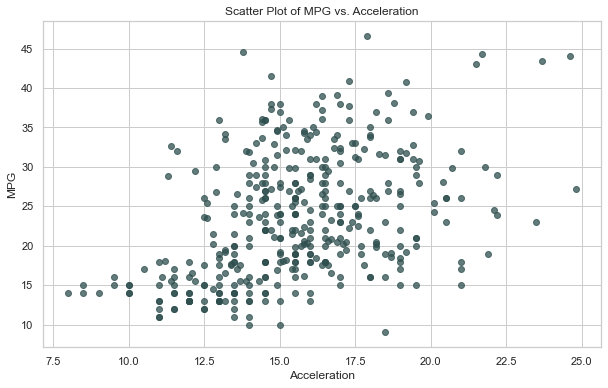

In [32]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(mpg.acceleration, mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("Acceleration")
axes.set_title("Scatter Plot of MPG vs. Acceleration")

plt.show()
plt.close()

This shows that there is a little correlation, but the data does look a lot like a cloud of points, rather than a line. 

There is also the question of why the correlation is positive. I had assumed that greater acceleration meant greater force, which meant greater horsepower, which probably meant lower `mpg`. However, it seems more likely now that the mass term in Newton's second law has a larger effect than the force term. 

$$ a = \frac{F}{m} $$

Overall, `acceleration` will be less of a good predictor of `mpg` than I had exepcted.

<a id="v_model_year"></a>

### 1.2.12 MPG vs. Model Year

As mentioned above, in 1978 the US government started enforcing Corporate Average Fuel Economy [(CAFE)](https://en.wikipedia.org/wiki/Corporate_average_fuel_economy) which required car manufacturers to increase the average mpg of their fleet. To this end, I would expect that the `mpg` will not change much depending on the year before 1978, and `mpg` will increase with the year after 1978. 

In [33]:
print("r = ", stats.pearsonr(mpg.mpg, mpg.model_year)[0])
print("ρ = ", stats.spearmanr(mpg.mpg, mpg.model_year)[0])

r =  0.5792671330833096
ρ =  0.573468703192175


It looks like there is a bit of a correlation between `mpg` and `model_year`, and it seems like it is mostly linear.

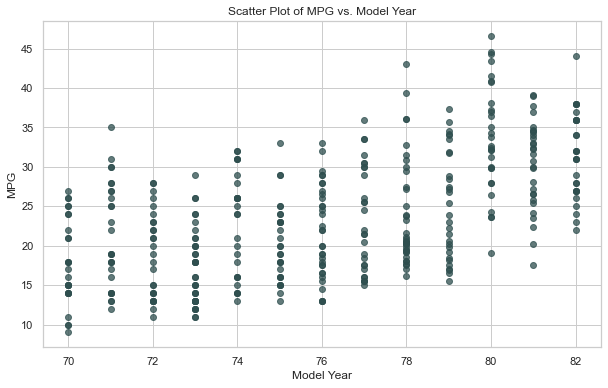

In [34]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(mpg.model_year, mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("Model Year")
axes.set_title("Scatter Plot of MPG vs. Model Year")

plt.show()
plt.close()

It looks like there is a little bit of improvement in `mpg` as model year increases. However, we can see that there is still a very large spread in `mpg` every year. The data here looks a little like it curves upwards. If we make the relationship exponential, would that affect the correlation coefficients?

In [35]:
print("r = ", stats.pearsonr(np.exp(mpg.mpg), mpg.model_year)[0])
print("ρ = ", stats.spearmanr(np.exp(mpg.mpg), mpg.model_year)[0])

r =  0.07567816766937883
ρ =  0.573468703192175


This is interesting! We've almost completely removed any linear correlation between the two, but there is still a monotonic relationship (and it's almost the same as before). This makes me think that no transformation is better than an exponential one.

<a id="v_cylinders"></a>

### 1.2.13 MPG vs. Cylinders

In general, the more cylinders an engine has, the power it can produce (assuming displacement is constant) because it is burning more fuel. This makes me think that as `cylinders` increases, `mpg` will decrease. Let's see what sort of correlation might exist.

In [36]:
print("r = ", stats.pearsonr(mpg.mpg, mpg.cylinders)[0])
print("ρ = ", stats.spearmanr(mpg.mpg, mpg.cylinders)[0])

r =  -0.7753962854205542
ρ =  -0.8218644914450965


We were correct about the sign of the correlation. Furthermore, it seems like `cylinders` will be good at predicting the `mpg` of a car. Because Spearman's correlation coefficient has a larger absolute value than Pearson's, there may be a transform that can help us. 

In [37]:
def rand_jitter(arr):
    """https://stackoverflow.com/a/21276920/9158985"""
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

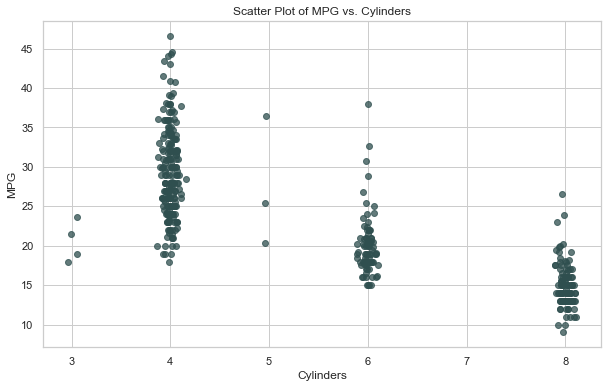

In [38]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(rand_jitter(mpg.cylinders), mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("Cylinders")
axes.set_title("Scatter Plot of MPG vs. Cylinders")

plt.show()
plt.close()

There is a very obvious linear trend here. Because there are so few values here, it begs the question of whether it should be modeled as a quantative or categorical regressor when building the model. This will certainly be something to investigate further. 

If we were to fit a line through this, I would guess that it looks vaguely like a reciprocal curve ($mpg \sim \frac{1}{cylinders}$). Let's check the correlations and plot this and see if we do indeed get something more linear

In [39]:
print("r = ", stats.pearsonr(mpg.mpg, 1/mpg.cylinders)[0])
print("ρ = ", stats.spearmanr(mpg.mpg, 1/mpg.cylinders)[0])

r =  0.7640899129026042
ρ =  0.8218644914450965


The linear relationship has actually decreased a bit, and the rank relationship hasn't changed much at all. 

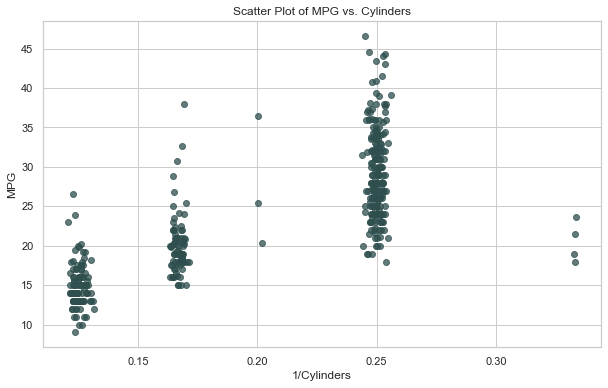

In [40]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(rand_jitter(1/mpg.cylinders), mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("1/Cylinders")
axes.set_title("Scatter Plot of MPG vs. Cylinders")

plt.show()
plt.close()

This plot looks a like a mirrored version of what we already had. And since the correlation coefficients haven't changed much, it leads me tho think that this transformation might not be worth it.

<a id="v_horsepower"></a>

### 1.2.13 MPG vs. Horsepower

Horsepower represents the maximum horsepower of the car. More specifically, I'm guessing it refers to the maximum horsepower of the engine, which is not necessarily the power transfered to the wheels; there are likely all sorts of mechanical energy losses between the engine and the wheels. In general, I would expect that cars which can produce more power, have lower `mpg`s; a negative correlation.

Note that to calculate Pearson's and Spearman's correlation coefficients, I will have to remove the missing horsepower data points.

In [41]:
no_nans = mpg.loc[mpg.horsepower.notna()]
print("r = ", stats.pearsonr(no_nans.mpg, no_nans.horsepower)[0])
print("ρ = ", stats.spearmanr(no_nans.mpg, no_nans.horsepower)[0])

r =  -0.7784267838977761
ρ =  -0.8536164024453882


Indeed, our prediction of the sign of the correlation is correct: it is negative. Horsepower seems to be a pretty good predictor of `mpg`.

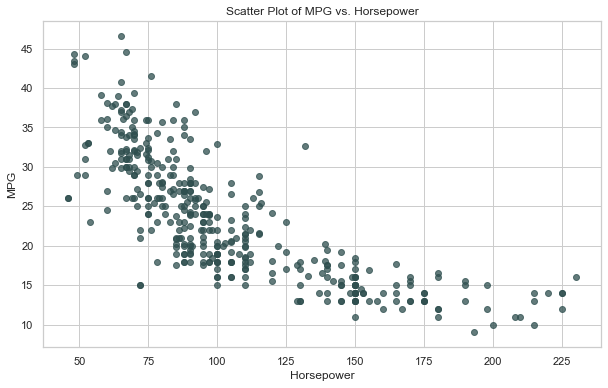

In [42]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(mpg.horsepower, mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("Horsepower")
axes.set_title("Scatter Plot of MPG vs. Horsepower")

plt.show()
plt.close()

Like `weight`, I see a bit of a curve in this scatter plot. Let's try putting it on a log scale and see how that changes it.

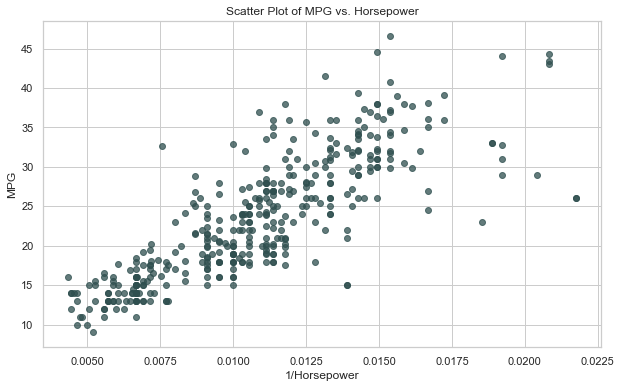

In [43]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(1/mpg.horsepower, mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("1/Horsepower")
axes.set_title("Scatter Plot of MPG vs. Horsepower")
# axes.set_yscale("log")

plt.show()
plt.close()

This is somewhat more linear. Are the correlation coefficients any higher?

In [44]:
print("r = ", stats.pearsonr(no_nans.mpg, 1/no_nans.horsepower)[0])
print("ρ = ", stats.spearmanr(no_nans.mpg, 1/no_nans.horsepower)[0])

r =  0.8167670895421582
ρ =  0.8536164024453882


This gave us a slight increase in Pearson's coefficient. This may be a useful transformation to make during model building. 

<a id="v_displacement"></a>

### 1.2.14 MPG vs. Displacement

Displacement is the total volume displaced during a complete cycle of the engine. A large displacement usually means more fuel is burned (assuming a constant amount of fuel is injected per unit volume). My guess that that `displacement` will be very similar to `weight` and `horsepower` in its relationship with `mpg`: as `displacement` increases, `mpg` decreases. 

In [45]:
print("r = ", stats.pearsonr(mpg.mpg, mpg.displacement)[0])
print("ρ = ", stats.spearmanr(mpg.mpg, mpg.displacement)[0])

r =  -0.8042028248058978
ρ =  -0.8556920118178749


The sign of the correlation is as we expected. It also seems like `displacement` might be a pretty good predictor of `mpg`. Also of note is that the rank correlation is greater than the linear correlation. If this relationship is similar to that of `weight` and `horsepower`, then a reciprocal relationship might improve Pearson's.

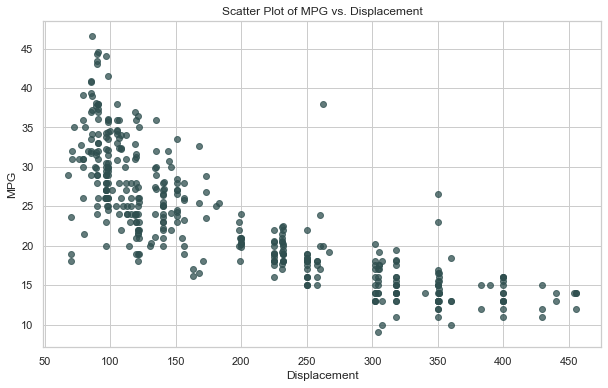

In [46]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(mpg.displacement, mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("Displacement")
axes.set_title("Scatter Plot of MPG vs. Displacement")

plt.show()
plt.close()

This definitely seems to show a reciprocal relationship.

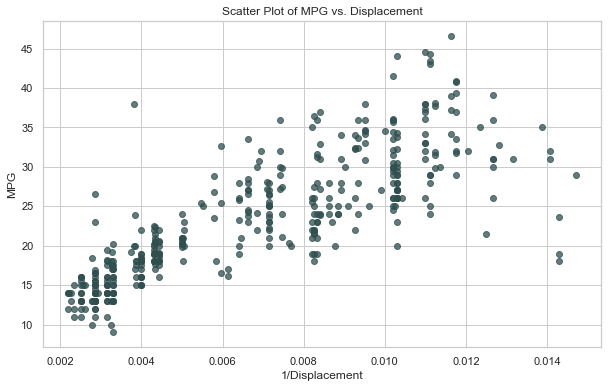

In [47]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(1/mpg.displacement, mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("1/Displacement")
axes.set_title("Scatter Plot of MPG vs. Displacement")

plt.show()
plt.close()

In [48]:
print("r = ", stats.pearsonr(mpg.mpg, 1/mpg.displacement)[0])
print("ρ = ", stats.spearmanr(mpg.mpg, 1/mpg.displacement)[0])

r =  0.8138037993844046
ρ =  0.8556920118178749


The linear correlation has improved a bit, but not much. Again, it might be worth adding this transformation to the model building.

<a id="v_origin"></a>

### 1.2.15 MPG vs. Origin

I believe the `origin` in this dataset refers to cars from Europe, North America, and Asia. The majority of cars are from origin 1, and the rest are spread almost evenly between origin 2 and 3. Based on my own personal experience, I would guess that during the timeframe this data was collected in, cars from origin 1 will have a lower `mpg` than those from origins 2 or 3.

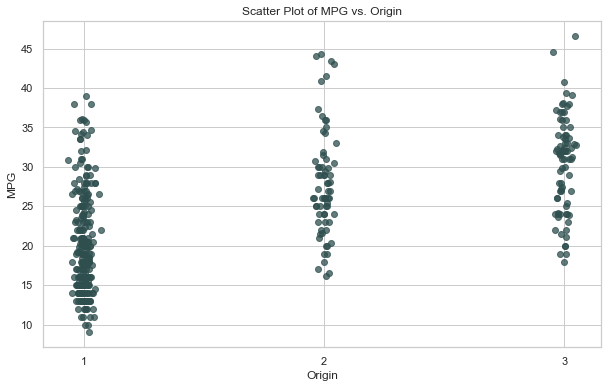

In [49]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(rand_jitter(mpg.origin), mpg.mpg, marker="o", color="darkslategray", alpha=0.75)

axes.set_ylabel("MPG")
axes.set_xlabel("Origin")
axes.set_xticks([1, 2, 3])
# axes.set_xticklabels()
axes.set_title("Scatter Plot of MPG vs. Origin")

plt.show()
plt.close()

My guess was to some extent correct: cars from origins 2 and 3 seem to have a slightly higher `mpg` than those from origin 1. To get a better feel for how these three categories interact, let's create empirical cumulative distribution plots

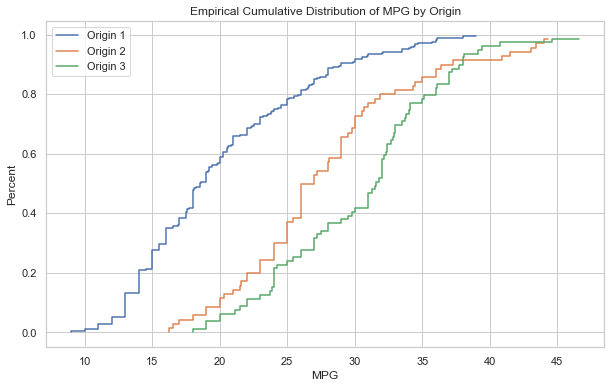

In [50]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

origin1 = np.sort(mpg.mpg.loc[mpg.origin.eq(1)])
y1 = np.arange(len(origin1))/float(len(origin1))
plt.step(origin1, y1, label="Origin 1")

origin2 = np.sort(mpg.mpg.loc[mpg.origin.eq(2)])
y2 = np.arange(len(origin2))/float(len(origin2))
plt.step(origin2, y2, label="Origin 2")

origin3 = np.sort(mpg.mpg.loc[mpg.origin.eq(3)])
y3 = np.arange(len(origin3))/float(len(origin3))
plt.step(origin3, y3, label="Origin 3")

axes.set_ylabel("Percent")
axes.set_xlabel("MPG")
axes.set_title("Empirical Cumulative Distribution of MPG by Origin")
axes.legend()

plt.show()
plt.close()

How do we read this plot? It is just like a plot of a cumulative distribution function for a statistical distribution, but created only using the data at hand. We can read it as follows: If we go up the 20-mpg line to the origin 1 curve, we see that 60% of cars from origin 1 have 20mpg or less. Likewise, Going up the 35-mpg line to the origin 3 curve, we see that 80% of cars from origin 3 have an mpg of 35 or less. 

[Back to top](#v_TOP)

---
<a id="v_build_model"></a>
## 1.3 - Build the model

Let's review the EDA we just carried out. What did we learn?

The data contains a target variable, `mpg`, and 8 regressors:

1. cylinders:     multi-valued discrete
1. displacement:  continuous
1. horsepower:    continuous
1. weight:        continuous
1. acceleration:  continuous
1. model year:    multi-valued discrete
1. origin:        multi-valued discrete
1. car name:      string (unique for each instance)

Having carried out our EDA, we might have a few thoughts on how to model some of regressors. 

- We will not use `car name` as a regressor, as there almost as many unique values as total values
- `origin` will be converted to two dummy variables
- `cylinders` correlates very strongly with `mpg`. We could model it as numerical or categorical. Perhaps try both and see which works best.
- `model_year` correlates somewhat with `mpg`. Even though it is a multi-valued discrete regressor, there are so many years that it likely would not be worth it to create dummy variables. 

Since we've decided to try `origin` as a dummy, let's go ahead and create the necessary columns

In [51]:
mpg.cylinders.unique()

array([8, 4, 6, 3, 5])

In [52]:
mpg = pd.concat([mpg, pd.get_dummies(mpg.origin)], axis=1).rename(columns={1:"origin_1", 2:"origin_2", 3:"origin_3"})
mpg = pd.concat([mpg, pd.get_dummies(mpg.cylinders, prefix = "cyl")], axis=1)
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,origin_1,origin_2,origin_3,cyl_3,cyl_4,cyl_5,cyl_6,cyl_8
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,1,0,0,0,0,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,1,0,0,0,0,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,1,0,0,0,0,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,1,0,0,0,0,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,1,0,0,0,0,0,0,1


Since we are doing linear regression, correlation will be very important to the performance of our model. We've already looked at the correlation for most of the regressors, but let's take another look.

In [53]:
from typing import List

def correlations(data: pd.DataFrame, y: str, xs: List[str]) -> pd.DataFrame:
    # First remove any rows with NaNs
    data = data.loc[data.notna().all(axis=1)]
    
    rs = [stats.pearsonr(data[y] , data[x])[0] for x in xs]
    ρs = [stats.spearmanr(data[y], data[x])[0] for x in xs]
    return pd.DataFrame({"feature": xs, "r": rs, "ρ": ρs}).set_index("feature")

In [54]:
correlations(mpg, "mpg", ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"])

,r,ρ
feature,,
cylinders,-0.777618,-0.823175
displacement,-0.805127,-0.855234
horsepower,-0.778427,-0.853616
weight,-0.832244,-0.875585
acceleration,0.423329,0.441539
model_year,0.580541,0.574841


We can see that several of these will be pretty good at predicting, and two or so not very good:

1. `cylinders`: There is a pretty clear negative correlation here. The larger spearman's suggests that it is not entirely linaer. 
1. `displacement`: Behaves similarly to `cylinders`, with slightly stronger correlation. However, in our EDA, we tested the correlation with a reciprocal transformation, and it was slightly better. 
1. `horsepower`: Again, similar to `cylinders` and `displacement`. Our EDA again showed a slight improvement in correlation using a reciprocal transformation.
1. `weight`: This is clearly the best predictor of the bunch. A reciprocal transform also improved the correlation slightly. Weight being the strongest predictor was what we expect. 
1. `acceleration`: There is some correlation here (~42%), most of it linear. 
1. `model_year`: There is about a 58% correlation between these two. 

Since our EDA showed some improvment in correlation for three of the variables by taking a log transform, let's add those columns to the data, and re-create this table 

In [55]:
mpg["weight_reciprocal"] = 1/mpg.weight
mpg["horsepower_reciprocal"] = 1/mpg.horsepower
mpg["displacement_reciprocal"] = 1/mpg.displacement

In [56]:
correlations(
    mpg, 
    "mpg", 
    [
        "cylinders", 
        "displacement", 
        "displacement_reciprocal", 
        "horsepower", 
        "horsepower_reciprocal", 
        "weight",
        "weight_reciprocal",
        "acceleration", 
        "model_year"
    ]
)

,r,ρ
feature,,
cylinders,-0.777618,-0.823175
displacement,-0.805127,-0.855234
displacement_reciprocal,0.812885,0.855234
horsepower,-0.778427,-0.853616
horsepower_reciprocal,0.816767,0.853616
weight,-0.832244,-0.875585
weight_reciprocal,0.840681,0.875585
acceleration,0.423329,0.441539
model_year,0.580541,0.574841


Looking at the new table, we can see that in all three cases, the reciprocal version performs slightly better than the regular version in terms of linear correlation. We'll use these reciprocal regressors when creating the model.

Knowing all this, let's try an initial model with no changes, and go from there

In [57]:
mpg.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin', 'car_name', 'origin_1',
       'origin_2', 'origin_3', 'cyl_3', 'cyl_4', 'cyl_5', 'cyl_6', 'cyl_8',
       'weight_reciprocal', 'horsepower_reciprocal',
       'displacement_reciprocal'],
      dtype='object')

In [58]:
import models

### Data As Is Model

In [59]:
model = "mpg ~ cylinders + displacement + horsepower + weight + acceleration + model_year + origin_1 + origin_2"
result = models.bootstrap_linear_regression(model, data=mpg)
models.describe_bootstrap_lr(result)

The correlation coefficient is 82%, a pretty good number for our first attempt! With $\sigma = 3.31$mpg, we have a pretty tight uncertainty group compared with the total range of `mpg`s seen in the dataset.

What can we say about our coefficients?
- The intercept is not of interest, since there are no cars with no cylinders, no horsepower, weigh nothing, can't accelerate, were never created, and come from no origin!
- The number of `cylinders` negatively affects the `mpg`. However, it is a bit of a suprise that there are positive values within the 95% Bayesian Confidence Interval. I would not have expected that is was possible for a car with more cylinders to have better mpg.
- `displacement` correlates positively! A surprise! I had been expecting from the EDA that more cylinders meant lower `mpg`
- `horsepower` negatively affects `mpg`. No big surprise here, although interesting that there are positive values within the 95% BCI
- `weight` is very firmly negative, as expected
- `acceleration` was expected to be a bit of a toss up, and it could go either way. However, the trend toward positive correlation is slightly unexpected.
- `model_year` has a positive trend as expected; as CAFE regulations kicked in, manufacturers increased the efficiency of their cars
- `origin`=1 is negative, as expected; american cars are not as efficient as imported cars
- `origin`=2 is slightly negative, but is close to having almost no effect on the `mpg`. Origin 2 is Europe
- `origin`=3 is when both `origin_1` and `origin_2` are 0, so in this case, that means that cars from origin 3 (Asia?) are probably more efficient.

Having tested the basic version, there are a few modifications we can:

- Use the reciprocals mentioned above
- Perform a transformation on the target variable `mpg` to get it closer to a normal distribution
- Try making `cylinders` a categorical variable

### With Reciprocal Transformations Model

In [60]:
model = "mpg ~ cylinders + displacement_reciprocal + horsepower_reciprocal + weight_reciprocal + acceleration + model_year + origin_1 + origin_2"
result = models.bootstrap_linear_regression(model, data=mpg)
models.describe_bootstrap_lr(result)

The correlation coefficient is now 86%, about 4% better than our first attempt. 

What can we say about the changes to our coefficients?
- `displacement_reciprocal`is a bit above 0. The 95% BCI says it very well could be positive or negative. With our new reciprocal values, a more positive value means a smaller original value and vice versa. 
- `horsepower_reciprocal` is very firmly positive
- `weight_reciprocal` is also very firmly positive
- The other coefficients have all shifted slightly

### Log MPG Model (with reciprocal transformations)

Next up, we said it would be good to get `mpg` closer to a normal distribution. Let's take a look at it in its current form again, and see what transformation might be best

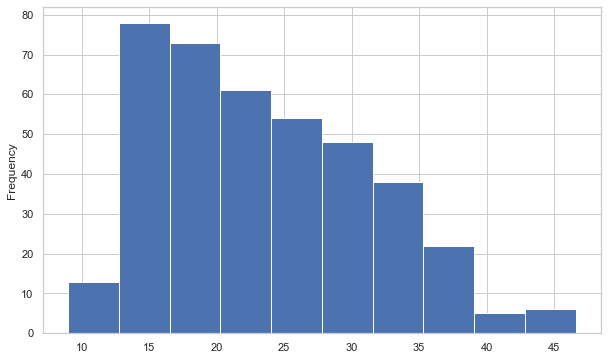

In [61]:
mpg.mpg.plot.hist(figsize = (10,6))

One possible hope might be to carry out a log transform. Let's do that and overlay the fitted lognormal PDF on our histogram. From scipy's [page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) on the lognormal distribution

> A common parametrization for a lognormal random variable $Y$ is in terms of the mean, $\mu$, and standard deviation, $\sigma$, of the unique normally distributed random variable $X$ such that $\text{exp}(X) = Y$. This parametrization corresponds to setting $s = \sigma$ and $\text{scale} = \text{exp}(\mu)$.

In [62]:
from scipy.stats import lognorm

In [63]:
# Create the log variable
mpg["log_mpg"] = np.log(mpg.mpg)

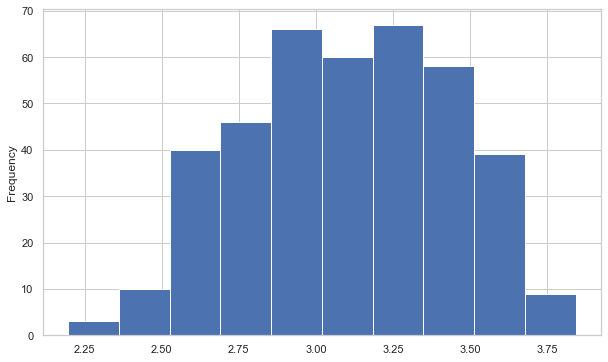

In [64]:
mpg.log_mpg.plot.hist(figsize = (10,6))

This is closer to a normal distribution, but it has a slight negative skew.

In [65]:
# Calculate s, scale, and location of `mpg` if it did follow a lognormal distribution
s, loc, scale = lognorm.fit(mpg.mpg)
print(f"s = {s:.2f}, loc = {loc:.2f}, scale = {scale:.2f}")

s = 0.31, loc = -1.85, scale = 24.18


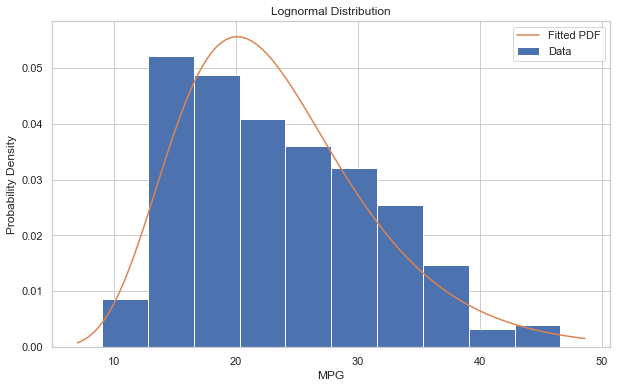

In [66]:
# What does the pdf of a lognormal distrbution look like with this scale parameter
x = np.linspace(mpg.mpg.min()-2, mpg.mpg.max()+2, 100)
my_pdf = lognorm.pdf(x, s, loc = loc, scale = scale)

# Create the figure
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)

# Plot the data
axes.hist(mpg.mpg, density = True, label = "Data")
axes.plot(x, my_pdf, label = "Fitted PDF")

# Make it pretty
axes.set_title("Lognormal Distribution")
axes.set_ylabel("Probability Density")
axes.set_xlabel("MPG")
axes.legend(loc = "best")

Clearly our PDF is not a perfect fit: the peak is not quite in the right place, and the slope after the peak is steeper than the actual data. But it is a pretty good approximation. Now let's try doing our linear regression with our newly logged `mpg`.

In [67]:
model = "log_mpg ~ cylinders + displacement_reciprocal + horsepower_reciprocal + weight_reciprocal + acceleration + model_year + origin_1 + origin_2"
result = models.bootstrap_linear_regression(model, data=mpg)
models.describe_bootstrap_lr(result)

Another increase in $R^2$, and a large reduction in $\sigma$ from 2.94 to 0.12! Our model just became much more accurate!

### Cylinders as Categorical Variable

We also said we would test if `cylinders` worked better as a continuous regressor, or as a categorical one. Let's try that now.

In [68]:
model = "log_mpg ~ displacement_reciprocal + horsepower_reciprocal + weight_reciprocal + acceleration + model_year + origin_1 + origin_2 + cyl_3 + cyl_4 + cyl_5 + cyl_6"
result = models.bootstrap_linear_regression(model, data=mpg)
models.describe_bootstrap_lr(result)

Now that we've carried out this transformation, perhaps the reciprocal transforms that we did earlier are no longer necessary? Let's try it out and compare the results

### Log MPG Model

In [69]:
model = "log_mpg ~ displacement + horsepower + weight + acceleration + model_year + origin_1 + origin_2 + cyl_3 + cyl_4 + cyl_5 + cyl_6"
result = models.bootstrap_linear_regression(model, data=mpg)
models.describe_bootstrap_lr(result)

The $R^2$ and $\sigma$ have barely changed, but the 95% BCI for $R^2$ has gone from 0.91 to 0.92; not much of a change, but it's better than nothing. Let's keep the model without the reciprocals

Text(0.5, 0, 'Residual Index')

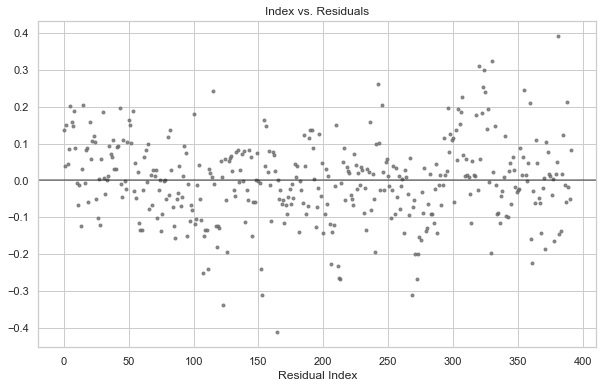

In [70]:
fig = plt.figure(figsize = (10,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(list(range(0, mpg.notna().all(axis=1).sum())), result["residuals"], '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result["n"], c="black", alpha=0.5)
axes.set_title("Index vs. Residuals")
axes.set_xlabel("Residual Index")

There are not any obvious patterns that I can see here, but we are also not sorting by any particular feature. Let's try sorting by individual features now to see if we can spot any trends

In [71]:
def plot_residuals_sorted(data, result, feature):
        
    # Remove any NaN rows that exist
    data = data.dropna()
        
    # Sort the residuals by `feature`
    data["residual"] = result["residuals"]
    sorted_resids = data.sort_values(by = feature).residual
    sorted_feature = data.sort_values(by = feature)[feature]
    
    fig = plt.figure(figsize = (10,6))

    ax1 = fig.add_subplot(1, 1, 1)
    ax1.scatter(
        list(range(0, data.shape[0])),
        sorted_resids,
        color="dimgray",
        alpha=0.75
    )
    
    ax1.axhline(
        y=0.0,
        xmin=0,
        xmax=result["n"],
        c="black",
        alpha=0.5
    )
    
    ax1.set_title(f"Index vs. Residuals\nSorted by {feature}")
    ax1.set_xlabel("Residual Index")

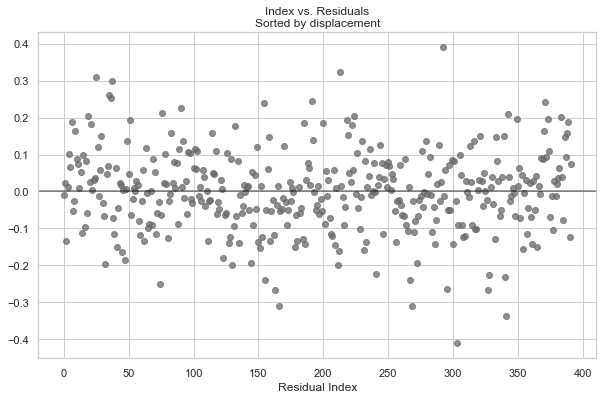

In [73]:
plot_residuals_sorted(mpg, result, "displacement")

These residuals look pretty random, as far as I can tell

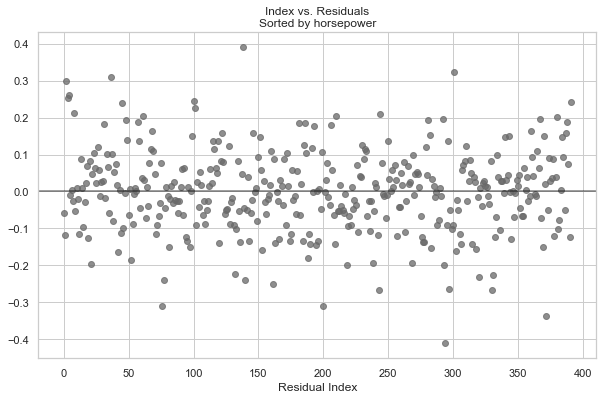

In [74]:
plot_residuals_sorted(mpg, result, "horsepower")

Again, nicely random

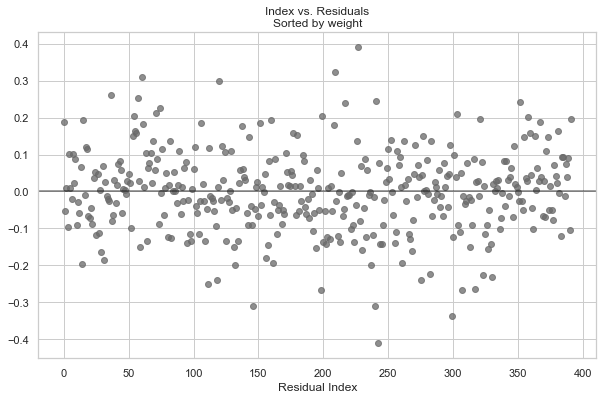

In [75]:
plot_residuals_sorted(mpg, result, "weight")

Again, looks random

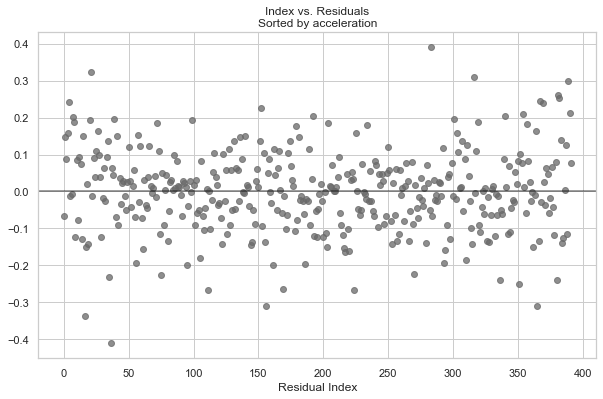

In [76]:
plot_residuals_sorted(mpg, result, "acceleration")

Nothing her

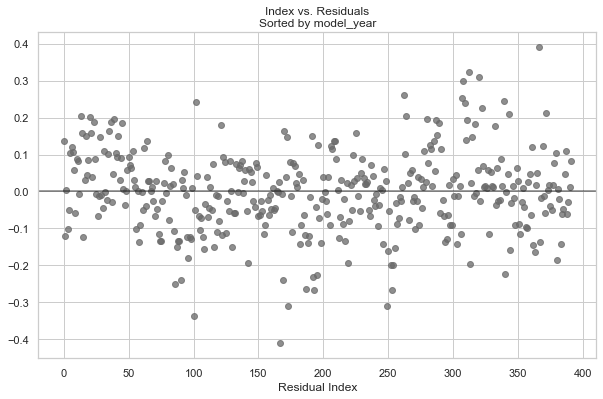

In [77]:
plot_residuals_sorted(mpg, result, "model_year")

Perhaps there is a bit of a pattern here: a slight U-shape in the data, with the data possibly growing more spread out as the model year increases. However, I would say that it is not enough of a trend that I will attempt a transform to fix it. 

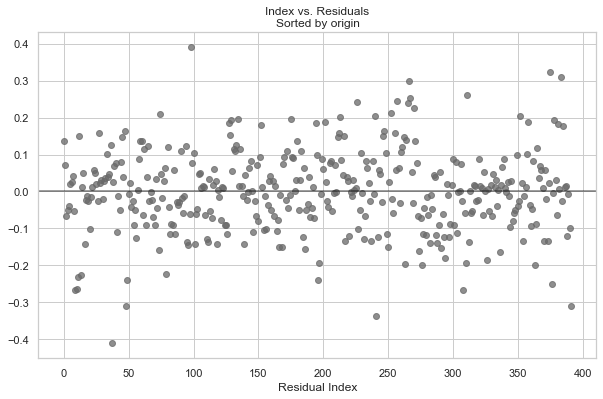

In [78]:
plot_residuals_sorted(mpg, result, "origin")

No noticeable pattern when sorting by `origin`

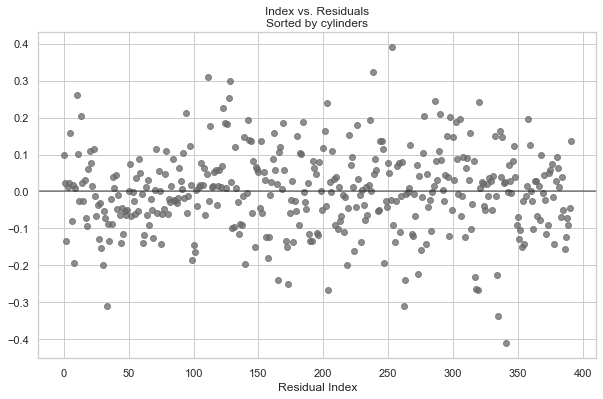

In [79]:
plot_residuals_sorted(mpg, result, "cylinders")

`cylinders` likewise looks pretty random. We have now checked all the variables for trends in the residuals by sorting by those variables, and did not find any trends of note.

### Further Model Evaluation
At this point, we've built a linear model, and checked for likely transformations, and checked for unlikely looking residuals. Now, let's move onto things like cross-validation.

In [80]:
# Copying code from the Lab 11 solution
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [81]:
result = cross_validation(models.linear_regression, model, mpg, lambda r: (r["sigma"], r["r_squared"]))

From Lab 11 solution:

>It's a bit easy to get confused here if you're not sure what you really want. 
>
>In the results above, we have the metric ($\sigma$ or $R^2$) and the 95% credible intervals for the *metric*. Now we have 30 estimates of each metric. That's sufficient to estimate credible bounds. We can just get the quantiles. That is, 3 rounds of 10 fold cross validation is already a kind of Bootstrap estimate of the metric:

In [82]:
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in result], [0.025, 0.975]))

95% CI for sigma: [0.10818617 0.16611127]


In [83]:
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in result], [0.025, 0.975]))

95% CI for R^2: [0.79928029 0.93750447]


Now that we've carried out the cross-validation, we can estimate how well our model might perform on new data that we haven't yet seen. In the cells directly above, we computed quantiles directly from 30 samples. Now let's bootstrap those 30 samples for an even better estimate of our model's performance. 

Again, using code taken from the Lab 11 solution

In [84]:
sigmas = [r[0] for r in result]
r_squareds = [r[1] for r in result]

In [85]:
def resample(data):
    n = len(data)
    return [data[i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [86]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [87]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [0.12734809 0.13853269]


In [88]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.87300904 0.89679346]


We can be pretty confident in the error of our model, as well as in its correlation coefficient. 

[Back to top](#v_TOP)

---
<a id="v_describe_model"></a>
## 1.4 - Describe the model

[Back to top](#v_TOP)

---
<a id="v_use_model"></a>
## 1.5 - Use the model

[Back to top](#v_TOP)

---

**CHECK LIST**

Before you submit this assignent, go back and review the directions to ensure that you have followed each instruction.



*   Have you completed every section and answered every question asked?
*   For every question, have you described your approach and explained your results?
*   Have you checked for spelling and grammar errors?
*   Are your code blocks free of any errors?
*   Have you *SAVED* your notebook?

